In [15]:
import os
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader, Subset

class HandwrittenDigitsDataset(Dataset):
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.transform = transform
        self.image_files = [os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith('.png')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label_path = os.path.join(self.images_folder, os.path.basename(img_path).replace('.jpg', '.txt'))
        
        image = Image.open(img_path).convert('RGB')
        boxes = []
        labels = []
        
        with open(label_path, 'r') as file:
            for line in file.readlines():
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                boxes.append([x_center, y_center, width, height])
                labels.append(int(class_id))
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        if self.transform:
            image = self.transform(image)
        
        return image, boxes, labels

transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
path = "D:\Casper\OTHER\Data\\aML\hw6\HW6_train\\5\\"


train_dataset = HandwrittenDigitsDataset(path, transform)
print(len(train_dataset))

96000


In [16]:
def custom_collate_fn(batch):
    images = []
    labels = []

    for image, label in batch:
        images.append(image)
        labels.append(torch.tensor(label, dtype=torch.float32))
        
    images = torch.stack(images, 0)
    labels = torch.stack(labels, 0)

    return images, labels
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [19]:
def get_dataloaders(train_dataset, transform, train_ratio, val_ratio, batch_size):

    # obtain training indices that will be used for validation
    num_train = len(train_dataset)
    indices = list(range(num_train))
    print("--------- INDEX checking ---------")
    print(f"Original: {indices[:5]}")
    random.shuffle(indices)
    print(f"Shuffled: {indices[:5]}")
    print("--------- INDEX shuffled ---------\n")

    split_train = int(np.floor(train_ratio * num_train))
    split_val = split_train + int(np.floor(val_ratio * (num_train-split_train)))
    train_idx, val_idx, test_idx = indices[0:split_train], indices[split_train:split_val], indices[split_val:]
    merge_dataset = Subset(train_dataset, train_idx)

    # train_loader = DataLoader(merge_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)
    # val_loader = DataLoader(Subset(train_dataset, val_idx), batch_size=batch_size, collate_fn=custom_collate_fn)
    # test_loader = DataLoader(Subset(train_dataset, test_idx), batch_size=batch_size, collate_fn=custom_collate_fn)
    train_loader = DataLoader(merge_dataset, batch_size=batch_size)
    val_loader = DataLoader(Subset(train_dataset, val_idx), batch_size=batch_size)
    test_loader = DataLoader(Subset(train_dataset, test_idx), batch_size=batch_size)
    
    # check dataset
    print(f"Total number of samples: {num_train} datapoints")
    print(f"Number of train samples: {len(train_loader)} batches/ {len(train_loader.dataset)} datapoints")
    print(f"Number of val samples: {len(val_loader)} batches/ {len(val_loader.dataset)} datapoints")
    print(f"Number of test samples: {len(test_loader)} batches/ {len(test_loader.dataset)} datapoints")
    print(f"Data Transform: {transform}")
    print(f"")
    
    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }
    return dataloaders

In [20]:
loaders = get_dataloaders(train_dataset, transform, 0.6, 0.5, 64)


--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [20016, 1926, 24856, 58847, 15539]
--------- INDEX shuffled ---------

Total number of samples: 96000 datapoints
Number of train samples: 900 batches/ 57600 datapoints
Number of val samples: 300 batches/ 19200 datapoints
Number of test samples: 300 batches/ 19200 datapoints
Data Transform: Compose(
    Resize(size=(416, 416), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)



In [22]:
def display_image_and_tensor(dataset, index):
    image, box, label = dataset[index]  # Get the first image and its label
    print("Label:\n", label)
    image_np = image.squeeze().numpy()  
    plt.imshow(image_np, cmap='gray')
    plt.show()

display_image_and_tensor(train_dataset, 1)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

In [7]:
count = 0
for label in train_loader:
    count +=1
    if count >5:
        print(len(label[0]))
        break

8


In [8]:


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 4 * 5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 4, 5)  # Reshape to (batch_size, 4, 5)
        return x

model = SimpleCNN()


In [9]:
import torch.nn as nn

class YOLO_basic(nn.Module):
    def __init__(self, num_classes):
        super(YOLO_basic, self).__init__()
        self.num_classes = num_classes
        
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        )
        
        self.head = nn.Conv2d(1024, self.num_classes + 5, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

num_classes = 10  # Assuming we have 10 classes (digits 0-9)
model = YOLO_basic(num_classes=num_classes)

In [10]:
def calculate_iou(pred_box, true_box):
    """
    Calculate the IoU of two bounding boxes.

    Parameters:
    pred_box (Tensor): Predicted bounding box of shape (4,) in the format [x, y, w, h].
    true_box (Tensor): True bounding box of shape (4,) in the format [x, y, w, h].

    Returns:
    float: IoU value.
    """
    if isinstance(pred_box, np.ndarray):
        pred_box = torch.tensor(pred_box)
    if isinstance(true_box, np.ndarray):
        true_box = torch.tensor(true_box)
    # Transform from center coordinates to corner coordinates
    pred_box = pred_box.unsqueeze(0)
    true_box = true_box.unsqueeze(0)
    pred_box = torch.cat([pred_box[..., :2] - pred_box[..., 2:] / 2,
                          pred_box[..., :2] + pred_box[..., 2:] / 2], dim=-1)
    true_box = torch.cat([true_box[..., :2] - true_box[..., 2:] / 2,
                          true_box[..., :2] + true_box[..., 2:] / 2], dim=-1)

    # Calculate the intersection coordinates
    inter_top_left = torch.max(pred_box[..., :2], true_box[..., :2])
    inter_bottom_right = torch.min(pred_box[..., 2:], true_box[..., 2:])
    inter_dims = torch.clamp(inter_bottom_right - inter_top_left, min=0)

    # Intersection area
    inter_area = inter_dims[..., 0] * inter_dims[..., 1]

    # Calculate the area of both bounding boxes
    pred_area = (pred_box[..., 2] - pred_box[..., 0]) * (pred_box[..., 3] - pred_box[..., 1])
    true_area = (true_box[..., 2] - true_box[..., 0]) * (true_box[..., 3] - true_box[..., 1])

    # Union area
    union_area = pred_area + true_area - inter_area

    # IoU
    iou = inter_area / union_area
    return iou

In [11]:
def batch_iou(preds, labels):
    iou_scores = []
    for i in range(len(preds)):
        pred_boxes = preds[i]
        label_boxes = labels[i]
        for j in range(4):
            if label_boxes[j][0] == -1:  # Ignore padding labels
                continue
            iou = calculate_iou(pred_boxes[j][1:], label_boxes[j][1:])
            iou_scores.append(iou.item())
    return np.mean(iou_scores) if iou_scores else 0.0

In [12]:
def precision_recall(preds, labels, iou_threshold=0.5):
    preds = sorted(preds, key=lambda x: x[1], reverse=True)  # Sort by confidence score
    tp = 0
    fp = 0
    total_gt = len(labels)

    for pred in preds:
        pred_box = pred[2]
        best_iou = 0
        for label in labels:
            true_box = label[1:]
            iou = calculate_iou(pred_box, true_box)
            if iou > best_iou:
                best_iou = iou
        if best_iou > iou_threshold:
            tp += 1
        else:
            fp += 1

    fn = total_gt - tp
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    return precision, recall

def calculate_ap(precisions, recalls):
    # Ensure precision and recall arrays are of the same length
    precisions = np.concatenate(([0.0], precisions, [0.0]))
    recalls = np.concatenate(([0.0], recalls, [1.0]))

    # Ensure precision is a non-increasing function
    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])

    # Calculate the AP as the area under the precision-recall curve
    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])

    return ap

def calculate_map(preds, labels):
    precisions = []
    recalls = []

    for iou_threshold in np.arange(0.5, 1.0, 0.05):
        precision, recall = precision_recall(preds, labels, iou_threshold)
        precisions.append(precision)
        recalls.append(recall)

    ap = calculate_ap(np.array(precisions), np.array(recalls))
    return ap


In [13]:

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(50):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    count = 0
    all_preds = []
    all_labels = []
    for images,boxes, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Ensure outputs and labels are of the same shape
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # Collect all predictions and labels for mAP calculation
        for i in range(len(outputs)):
            preds = outputs[i].cpu().detach().numpy()
            labs = labels[i].cpu().detach().numpy()
            for j in range(4):
                if labs[j][0] != -1:  # Ignore padding labels
                    all_preds.append([labs[j][0], preds[j][0], preds[j][1:]])
                    all_labels.append([labs[j][0]] + labs[j][1:])
        iou = batch_iou(outputs.cpu().detach().numpy(), labels.cpu().detach().numpy())
        running_iou += iou

        # count += 1
        # if count > 100:
        #     break
    # map_score = calculate_map(all_preds, all_labels)
    print(f'Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader)}, IoU: {running_iou/len(train_loader)}')



  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[8, 1, 64, 64] to have 3 channels, but got 1 channels instead

In [13]:
model_scripted = torch.jit.script(model.cpu()) # Export to TorchScript
model_scripted.save('model_0525_0301.pt') # Save

In [14]:
def draw_bboxes(image, outputs):
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap='gray')
    image_size = image.shape
    height, width = image_size
    for i in range(outputs.shape[0]):
        # Extract the bounding box and class information
        conf = outputs[i, 0]
        if conf >= 0.0:  # Only consider boxes with confidence greater than a threshold
            class_id = outputs[i, 0]
            bbox = outputs[i, 1:]
            
            # Convert center coordinates to top-left corner coordinates
            x, y, w, h = bbox * np.array([width, height, width, height])
   
            
            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
            # Add class label
            plt.text(x, y, f'{int(class_id)}', color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()

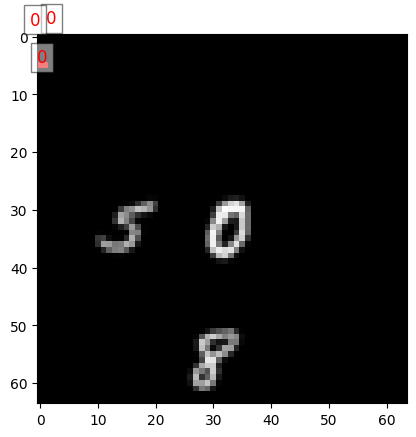

In [15]:

model.eval()
model.cuda()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        output = _[0].cpu().numpy()  # Take the first image in the batch
        output = outputs[0].cpu().numpy()  # Take the first image in the batch
        # print(_[0])
        # Draw bounding boxes on the image
        image_np = images[0].cpu().squeeze().numpy()
        # draw_bboxes(image_np, output)
        draw_bboxes(image_np, output)
        break

[[ 0.02378805  0.01853598 -0.03565462 -0.04894586 -0.03272058]
 [-0.01088141 -0.00963406 -0.02800906 -0.02980904 -0.00867223]
 [ 0.0243578  -0.02831009 -0.03938749 -0.05683305  0.0489378 ]
 [ 0.075145   -0.00931647  0.07143673  0.02102005  0.00863508]]


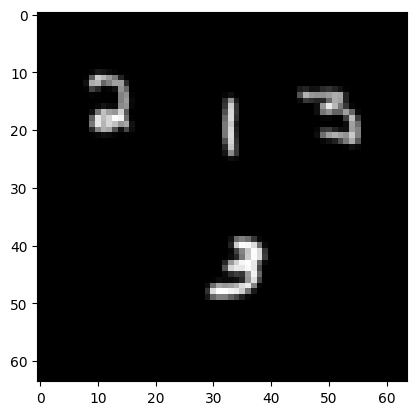

In [16]:
model.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        print(outputs[0].cpu().numpy())
        image_np = images[0].cpu().squeeze().numpy()  
        plt.imshow(image_np, cmap='gray')
        plt.show()
        break

In [ ]:
model = torch.jit.load('model_scripted.pt')
print(model)
model.eval()

In [20]:
class TEST_HandwrittenDigitsDataset(Dataset):
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.transform = transform
        self.image_files = [os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith('.png')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if self.transform:
            image = self.transform(image)
        return image
path = "D:\Casper\OTHER\Data\\aML\hw6\HW6_test\\"
test_dataset = TEST_HandwrittenDigitsDataset(path, transform)
print(len(test_dataset))

24000


In [24]:
def TEST_custom_collate_fn(batch):
    images = []
    for image in batch:
        images.append(image)
        
    images = torch.stack(images, 0)

    return images

In [25]:
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=TEST_custom_collate_fn)
# display_image_and_tensor(test_dataset, 1)


[[ 0.02645063  0.01764934 -0.03381348 -0.04880987 -0.03095962]
 [-0.0112573  -0.00536284 -0.02787279 -0.03068807 -0.00665993]
 [ 0.02349928 -0.02708736 -0.03882412 -0.06010732  0.04797538]
 [ 0.07101774 -0.00865807  0.07004333  0.02637316  0.01090862]]


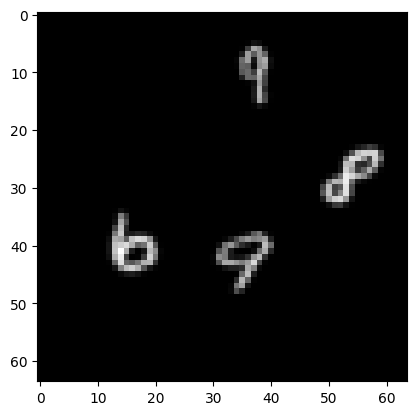

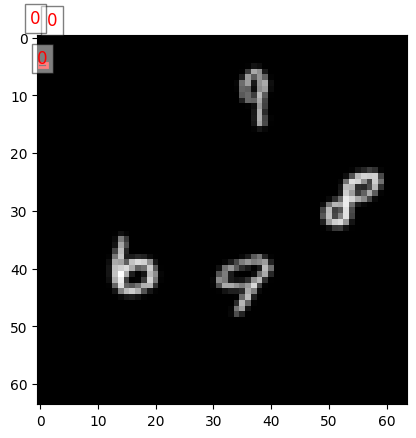

In [28]:
model.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        print(outputs[0].cpu().numpy())
        image_np = images[0].cpu().squeeze().numpy()  
        plt.imshow(image_np, cmap='gray')
        plt.show()
        output = outputs[0].cpu().numpy()  # Take the first image in the batch
        draw_bboxes(image_np, output)
        break